## 0. Library Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Add
from keras.models import Model 
from keras.regularizers import l2

import os
import matplotlib.pyplot as plt
from modules import create_dataset_csv
from modules import download_images

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

## 1. Generating a Dataset

In [3]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+"/data_dump/datasets/ds_test",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+"/data_dump/datasets/ds_test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 88468 files belonging to 2 classes.
Using 70775 files for training.
Found 88468 files belonging to 2 classes.
Using 17693 files for validation.


### Visualize the data

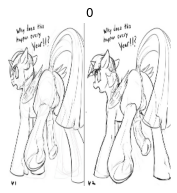

In [4]:
plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(int(labels[0]))
    plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

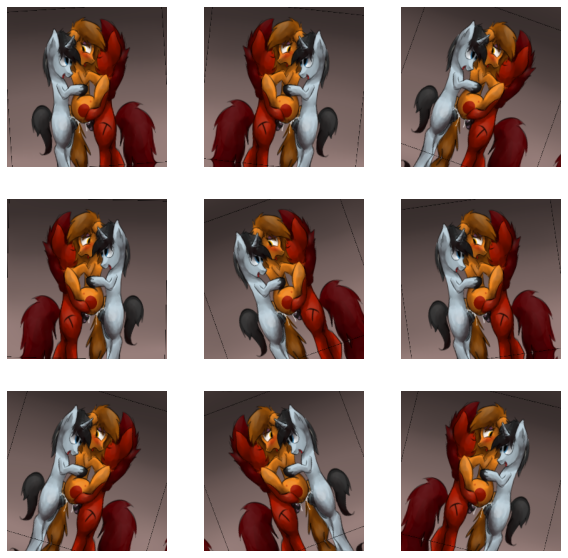

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 4. Building A Model

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [8]:
def res_identity(x, filters): 
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

In [9]:
def res_conv(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = ZeroPadding2D(padding=(3, 3))(inputs)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 128))
    x = res_identity(x, filters=(64, 128))
    #x = res_identity(x, filters=(64, 128))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 128))
    x = res_identity(x, filters=(128, 128))
    #x = res_identity(x, filters=(128, 128))
    #x = res_identity(x, filters=(128, 128))

    # 4th stage

    x = res_conv(x, s=2, filters=(128, 128))
    x = res_identity(x, filters=(128, 128))
    #x = res_identity(x, filters=(128, 128))
    #x = res_identity(x, filters=(128, 128))
    #x = res_identity(x, filters=(128, 128))
    #x = res_identity(x, filters=(128, 128))

    # 5th stage

    x = res_conv(x, s=2, filters=(128, 64))
    x = res_identity(x, filters=(128, 64))
    #x = res_identity(x, filters=(128, 64))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=inputs, outputs=x, name='Resnet50')

    return model
    


model = make_model(input_shape=image_size+(3,), num_classes=2)

## 5. Testing the Model with 1 Epoch

In [11]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

2212/2212 [==============================] - 1576s 713ms/step - loss: 1.5454 - accuracy: 0.4974 - val_loss: 0.7451 - val_accuracy: 0.4897


In [12]:
target_database_folder = "D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/"
if not os.path.exists(target_database_folder): os.makedirs(target_database_folder)
    
class1_tags = ["explicit","grotesque","questionable"]
class2_tags = ["safe"]

path_class1 = create_dataset_csv(class1_tags, 1, target_database_folder)
path_class2 = create_dataset_csv(class2_tags, 1, target_database_folder)

{'retrieve tag id': "SELECT id FROM new_tags WHERE name IN ('explicit','grotesque','questionable');"}
COPY (SELECT id, image_format, version_path FROM new_images WHERE id IN (SELECT image_id FROM new_image_taggings WHERE tag_id IN ('39068','29300','26707')) ORDER BY RANDOM() LIMIT 1) TO 'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/39068_29300_26707.csv' DELIMITER '|' CSV;
{'retrieve tag id': "SELECT id FROM new_tags WHERE name IN ('safe');"}
COPY (SELECT id, image_format, version_path FROM new_images WHERE id IN (SELECT image_id FROM new_image_taggings WHERE tag_id IN ('40482')) ORDER BY RANDOM() LIMIT 1) TO 'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/40482.csv' DELIMITER '|' CSV;


In [13]:
download_images(target_database_folder, path_class1)

#1 sent - #1 image downloaded - #0 errors caught so far.


In [14]:
download_images(target_database_folder, path_class2)

#1 sent - #1 image downloaded - #0 errors caught so far.


In [21]:
img = keras.preprocessing.image.load_img(target_database_folder+"39068_29300_26707/1579351.png", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image is %.2f percent class 0 and %.2f percent class 1."
    % (score[0], score[1])
)

img = keras.preprocessing.image.load_img(target_database_folder+"40482/2269808.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image is %.2f percent class 0 and %.2f percent class 1."
    % (score[0], score[1])
)

This image is 0.53 percent class 0 and 0.47 percent class 1.
This image is 0.51 percent class 0 and 0.49 percent class 1.


## 6. Testing a Model